# University ranks

## Introduction

The goal of this work is to answer the following questions:

* How  do  university  rankings  change  over  time?
* Which  characteristics  of  universities  contribute most to good rankings, or to large changes in the ranking position?
* How do these characteristics correlate with characteristics of cities or countries in which the university islocated?
* Are there predictors for increases or decreases in the rankings?

In the course of this work, these questions will be refined and precised before being answered.

The work is devided in three parts, which correspond to the steps in the data science process. First, we will load all necessary data. This includes also data cleaning. Then the data will be explored using plots and calculating descriptive statistics. The third step will be to model the data using ML models.

Before starting, we need to load the needed packages for data processing and visualisation:

In [1]:
import os
import numpy as np
import glob
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import re

pd.options.display.max_rows = 4

## Step 1: Load the data

We load the CWUR data and the Shanghai data. They are available at https://www.kaggle.com/mylesoneill/world-university-rankings. For the Shanghai data the respective countries of the universities have to be merged.

In [2]:
datapath = "data/university_data/"

#uni rankings
cwur = pd.read_csv(datapath + "/cwurData.csv", header=0)
shanghai = pd.read_csv(datapath + "/shanghaiData.csv", header=0)
times = pd.read_csv(datapath + "/timesData.csv", header=0)

#additional university information
uni2country = pd.read_csv(datapath + "/school_and_country_table.csv", header=0)

#country properties
educ_expenditure = pd.read_csv(datapath + "/education_expenditure_supplementary_data.csv",
                               header=0,
                               quotechar="\"")
nbupc = pd.read_csv("data/nbupc.tsv", header=0, sep="\t", engine='python')
inh = pd.read_csv("data/inh.csv", header=0, sep=",", quotechar = "\"")
hdi = pd.read_csv(datapath + "/Human_Development_Index.csv")
countr_reg = pd.read_csv(datapath + "/countries_region.csv")

## Step 2: Preprocessing

In [3]:
#reformat data so years are columns
hdi_ref = hdi.melt(id_vars=['HDI Rank', 'Country'], var_name='year', value_name='HDI')
hdi_ref['year'] = pd.to_numeric(hdi_ref['year'])

cwur = cwur.rename(columns={'institution': 'university_name'})
uni2country = uni2country.rename(columns={'school_name': 'university_name'})
countr_reg = countr_reg.rename(columns={'Country': 'country', 'Region': 'region'})
hdi_ref = hdi_ref.rename(columns={'Country': 'country', 'HDI Rank': 'hdi_rank', 'HDI':'hdi'})

#strip whitespace
hdi_ref['country'] = hdi_ref['country'].str.strip()
#set index
hdi_indexed = hdi_ref.set_index(['year', 'country'])
hdi_indexed = hdi_indexed.loc[(slice(2012, 2015))]
hdi_ref = hdi_indexed.reset_index()

nbupc = nbupc[["COUNTRY", "ALL"]]
nbupc.columns = ["country", "number of universities"]
nbupc["country"]=nbupc["country"].str.strip()

inh = inh[["Country Name", "2018"]]
inh.columns = ["country", "inhabitants"]

# clean the columns by stripping the string
educ_expenditure["institute_type"]=educ_expenditure["institute_type"].str.strip()

shanghai = shanghai[pd.notna(shanghai['university_name'])] #delete one row that is NAs only

In [4]:
#times[times.world_rank.str.contains('[^0-9]' ,regex = True)]['world_rank'].unique()

#replacing for example '201-250' with mean(201,250)
rangeRanks = times[times.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for ran in rangeRanks:
    parts = ran.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[ran] = str(avg)
times = times.replace({"world_rank": rangeRanksToAvg})

rangeRanks = shanghai[shanghai.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for ran in rangeRanks:
    parts = ran.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[ran] = str(avg)
shanghai = shanghai.replace({"world_rank": rangeRanksToAvg})

#replacing for example '=127' with 127
times['world_rank'] = times['world_rank'].apply(lambda x : re.sub("[^0-9]", "", str(x)))

times = times.astype({'world_rank': 'int64'})
shanghai = shanghai.astype({'world_rank': 'int64'})

In [5]:
country_dict = {"Czechia": "Czech Republic",
                 "Hong Kong, China (SAR)":"Hong Kong",
                 "Iran (Islamic Republic of)":"Iran",
                 "Korea (Republic of)" : "South Korea",
                 "Korea, Republic of" : "South Korea",
                 'Republic of Ireland':'Ireland',
                 'Russian Federation':'Russia',
                 'Slovakia':'Slovak Republic',
                 'United States of America':'USA',
                 'Unisted States of America':'USA',
                 "United States" : "USA",
                 'Unted Kingdom':'United Kingdom'}

uni_dict = {'ETH Zurich – Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Michigan':'University of Michigan, Ann Arbor',
            'University of Washington':'University of Washington - Seattle',
            'University of Illinois at Urbana-Champaign':'University of Illinois at Urbana–Champaign',
            'Washington University in St Louis':'Washington University in St. Louis',
            'University of Wisconsin':'University of Wisconsin–Madison',
            'University of Minnesota':'University of Minnesota, Twin Cities',
            'Massachusetts Institute of Technology (MIT)':'Massachusetts Institute of Technology',
            'University of Wisconsin - Madison':'University of Wisconsin–Madison',
            'The University of Tokyo':'University of Tokyo',
            'University of Michigan - Ann Arbor':'University of Michigan, Ann Arbor',
            'The Imperial College of Science, Technology and Medicine':'Imperial College London',
            'Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Colorado at Boulder':'University of Colorado Boulder',
            'The University of Texas at Austin':'University of Texas at Austin',
            'The University of Texas Southwestern Medical Center at Dallas':'University of Texas Southwestern Medical Center',
            'The University of Edinburgh':'University of Edinburgh'}

cwur = cwur.replace({"country": country_dict})
#shanghai doesn't have country information yet
times = times.replace({"country": country_dict})
uni2country = uni2country.replace({"country": country_dict})
educ_expenditure = educ_expenditure.replace({"country": country_dict})
countr_reg = countr_reg.replace({"country": country_dict})
hdi_ref = hdi_ref.replace({"country": country_dict})
nbupc = nbupc.replace({"country": country_dict})
inh = inh.replace({"country": country_dict})

cwur = cwur.replace({"university_name": uni_dict})
shanghai = shanghai.replace({"university_name": uni_dict})
times = times.replace({"university_name": uni_dict})
uni2country = uni2country.replace({"university_name": uni_dict})

In [6]:


# reformat the dataframe
# first we make a row for each year value and add a year column
years = [1995,2000,2005,2009,2010,2011]

concat_list = []
for year in years:
    cols = ["country","institute_type","direct_expenditure_type", str(year)]
    concat_df = educ_expenditure.copy()[cols]
    concat_df["year"]=year
    concat_df.rename(columns = {str(year) : "percentage of GDP"}, inplace=True)
    concat_list.append(concat_df)

educ_expenditure_processed = pd.concat(concat_list, axis=0, ignore_index=True, sort=False)


# now we transform the values of "institute type" and "direct_expenditure_type" into columns
# so that we obtain a column for each value of "institute_type" and "direct_expenditure_type"
institute_types = set(educ_expenditure_processed["institute_type"])
direct_expenditure_types = set(educ_expenditure_processed["direct_expenditure_type"])

merge_list = []
for institute_type in institute_types:
    for direct_expenditure_type in direct_expenditure_types:
        if direct_expenditure_type == "Public":
            # extract the data with the corresponding "institute_type" and "direct_expenditure_type"

            merge_df =educ_expenditure_processed[(educ_expenditure_processed["institute_type"]==institute_type) & 
                                       (educ_expenditure_processed["direct_expenditure_type"]==direct_expenditure_type)].copy()
            merge_df = merge_df[["country", "year", "percentage of GDP"]]
            merge_df.rename(columns = {"percentage of GDP": "percentage of GDP," + institute_type + " (public)"},
                           inplace=True)
            merge_list.append(merge_df)
            # and store the data separatly

# the data for every single "institute_type" and "direct_expenditure_type" is merged
for merge_df in merge_list[1:]:
    merge_list[0]=merge_list[0].merge(merge_df, on = ["country", "year"])

# take the merged data and set index and multicolumn
educ_expenditure_processed = merge_list[0]
educ_expenditure_processed.set_index(["year", "country"], inplace=True)
educ_expenditure_processed.columns = pd.MultiIndex.from_tuples(
    [(c.split(",")[0], c.split(",")[1]) for c in educ_expenditure_processed.columns]
     )
#display(educ_expenditure_processed)

educ_expenditure_processed11 = educ_expenditure_processed.reset_index()[
    educ_expenditure_processed.reset_index()["year"]==2011
]
educ_expenditure_processed11.set_index("year", inplace=True)
display(educ_expenditure_processed11)

print(educ_expenditure_processed11.isnull().values.any())
print(educ_expenditure_processed11.isnull().sum())

country                      percentage of GDP  \
                   Higher Education Institutions (public)   
year                                                        
2011  OECD Average                                    1.1   
2011     Australia                                    0.7   
...            ...                                    ...   
2011        Brazil                                    0.9   
2011        Russia                                    0.9   

                                                                               
     Elementary and Secondary Institutions (public) All Institutions (public)  
year                                                                           
2011                                            3.6                       5.3  
2011                                            3.5                       4.3  
...                                             ...                       ...  
2011                                            4.4                       5.9  
2011                                            2.0                       3.9  

[37 rows x 4 columns]

True
country                                                              0
percentage of GDP  Higher Education Institutions (public)            4
                   Elementary and Secondary Institutions (public)    3
                   All Institutions (public)                         4
dtype: int64


In [7]:
# merge expenditure to cwur data
cwur_exp=educ_expenditure_processed.merge(cwur, on = ["country"]).copy()
display(cwur_exp)
print(cwur_exp.isnull().sum())

C:\Users\gabib\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,country,"(percentage of GDP, Higher Education Institutions (public))","(percentage of GDP, Elementary and Secondary Institutions (public))","(percentage of GDP, All Institutions (public))",world_rank,university_name,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,Australia,1.2,3.2,4.5,92,University of Queensland,1,101,101,101,67,90,89,NaN,46,44.18,2012
1,Australia,1.2,3.2,4.5,94,University of Sydney,2,101,101,101,56,92,85,NaN,69,44.13,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,Russia,0.9,2.0,3.9,755,National Research Nuclear University MEPhI,4,306,567,218,957,699,428,671.0,871,44.29,2015
11105,Russia,0.9,2.0,3.9,985,Novosibirsk State University,5,167,567,218,819,858,645,991.0,871,44.04,2015


country                                                          0
(percentage of GDP, Higher Education Institutions (public))    425
                                                              ... 
score                                                            0
year                                                             0
Length: 17, dtype: int64


In [8]:
inh = inh.merge(nbupc, on = ["country"])
display(inh)

cwur_inh=inh.merge(cwur, on = ["country"]).copy()
cwur_inh["universities per inhabitant"] = 10**7 *cwur_inh["number of universities"] / cwur_inh["inhabitants"]
display(cwur_inh)

cwur_exp=cwur_exp.merge(inh, on = "country")

,country,inhabitants,number of universities
0,Aruba,105845.0,3.0
1,Afghanistan,37172386.0,88.0
...,...,...,...
175,Zambia,17351822.0,22.0
176,Zimbabwe,14439018.0,15.0


,country,inhabitants,number of universities,world_rank,university_name,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year,universities per inhabitant
0,United Arab Emirates,9630959.0,63.0,924,United Arab Emirates University,1,355,478,210,983,821,800,897.0,426,44.36,2014,65.414047
1,United Arab Emirates,9630959.0,63.0,950,United Arab Emirates University,1,367,521,218,994,851,812,906.0,689,44.08,2015,65.414047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,South Africa,57779622.0,120.0,478,University of KwaZulu-Natal,4,367,148,218,562,397,368,579.0,539,44.85,2015,20.768568
2045,South Africa,57779622.0,120.0,678,University of Pretoria,5,367,262,218,620,513,511,741.0,604,44.39,2015,20.768568


In [9]:
#check missing values in cwur data
print('CWUR values')

print(cwur.isnull().values.any())
print(cwur.isnull().sum())

print('-----------------------')
#check missing values in cwur data
print('SHANGHAI values')
print(shanghai.isnull().values.any())
print(shanghai.isnull().sum())

CWUR values
True
world_rank         0
university_name    0
                  ..
score              0
year               0
Length: 14, dtype: int64
-----------------------
SHANGHAI values
True
world_rank         0
university_name    0
                  ..
pcp                1
year               0
Length: 11, dtype: int64


In [10]:
shanghai = pd.merge(shanghai, uni2country, how='left', on='university_name')
shanghai['country'] = shanghai['country'].fillna('unknown')

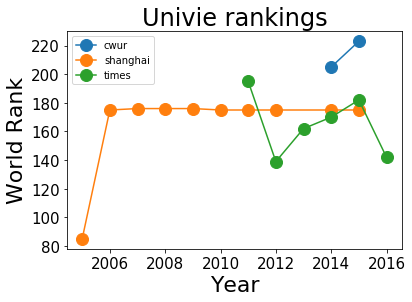

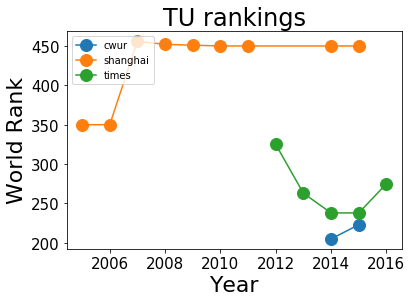

In [11]:
cwur_univie = cwur[cwur.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
cwur_univie['survey'] = "cwur"
times_univie = times[times.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
times_univie['survey'] = "times"
shanghai_univie = shanghai[shanghai.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
shanghai_univie['survey'] = "shanghai"
all_surveys_univie = cwur_univie.append(times_univie).append(shanghai_univie)

cwur_TU = cwur[cwur.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
cwur_TU['survey'] = "cwur"
times_TU = times[times.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
times_TU['survey'] = "times"
shanghai_TU = shanghai[shanghai.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
shanghai_TU['survey'] = "shanghai"
all_surveys_TU = cwur_univie.append(times_TU).append(shanghai_TU)

groups_univie = all_surveys_univie.groupby('survey')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_univie:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("Univie rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

groups_TU = all_surveys_TU.groupby('survey')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_TU:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("TU rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

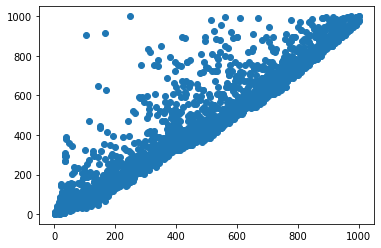

In [12]:
#First glance at the data suggests, that the missing value column broad impact seems to correlate with world rank:
plt.scatter(cwur['world_rank'], cwur['broad_impact'])


#Use Encoder to encode categories (country, institution)
encInst = sk.preprocessing.LabelEncoder().fit(cwur['university_name'])
encCon = sk.preprocessing.LabelEncoder().fit(cwur['country'])

cwur['university_name']  = encInst.transform(cwur['university_name'])
cwur['country'] =  encCon.transform(cwur['country'])

#general cutoff for imputation without introducing biass is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(cwur)

cwur_imputed = pd.DataFrame(imp.transform(cwur), columns = cwur.columns)

[(-9.0, 1010.0)]

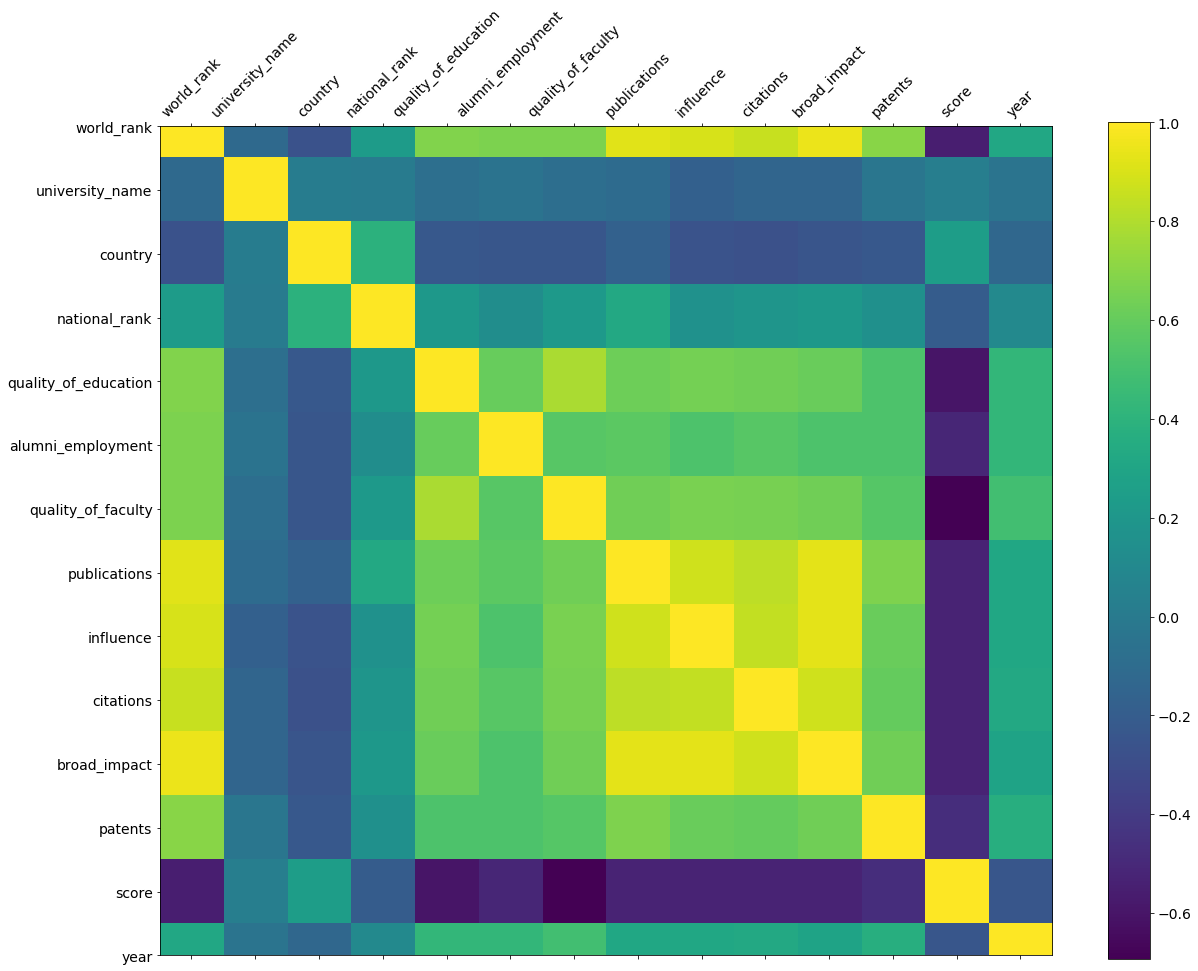

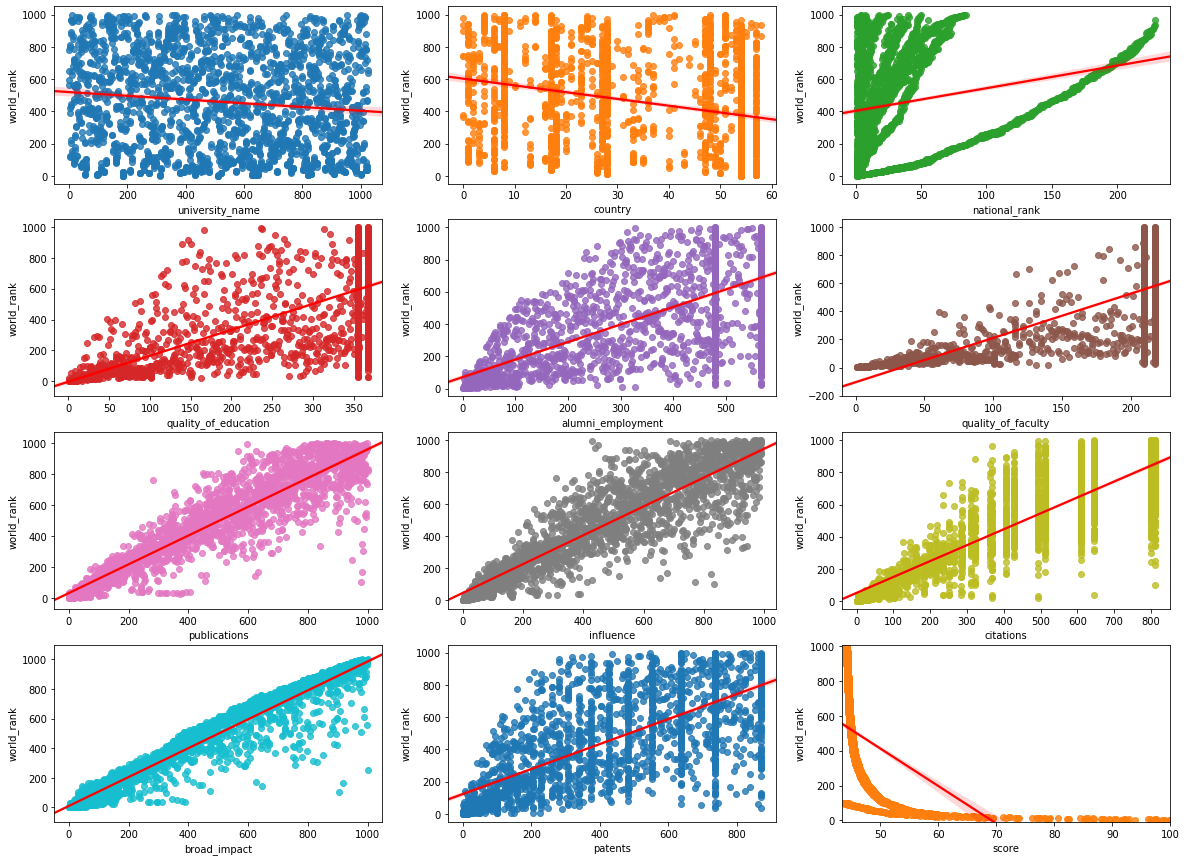

In [13]:
#Visualize Data

#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_imputed.corr(), fignum=fig1.number)
plt.xticks(range(cwur_imputed.shape[1]), cwur_imputed.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_imputed.shape[1]), cwur_imputed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#scatterplots vs. world rank

fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

sb.regplot(y='world_rank', x='university_name', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,0])
sb.regplot(y='world_rank', x='country', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,1])
sb.regplot(y='world_rank', x='national_rank', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[0,2])

sb.regplot(y='world_rank', x='quality_of_education', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,0])
sb.regplot(y='world_rank', x='alumni_employment', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,1])
sb.regplot(y='world_rank', x='quality_of_faculty', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[1,2])

sb.regplot(y='world_rank', x='publications', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,0])
sb.regplot(y='world_rank', x='influence', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,1])
sb.regplot(y='world_rank', x='citations', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[2,2])

sb.regplot(y='world_rank', x='broad_impact', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,0])
sb.regplot(y='world_rank', x='patents', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,1])
sb.regplot(y='world_rank', x='score', data=cwur_imputed,  line_kws = {'color':'red'}, ax=axs[3,2])
axs[3,2].set(xlim=(cwur_imputed['score'].min(), cwur_imputed['score'].max()))
axs[3,2].set(ylim=(cwur_imputed['world_rank'].min()-10, cwur_imputed['world_rank'].max()+10))




In [14]:
#we check rankings by region, first we clean the  data so it can be merged with cwur

#first we transform back our label encoding so we can merge
cwur_imputed['country'] = encCon.inverse_transform(cwur['country'])
cwur_imputed['university_name'] = encInst.inverse_transform(cwur['university_name'])

#strip names off whitespace
countr_reg['country'] = countr_reg['country'].str.strip()
countr_reg['region'] = countr_reg['region'].str.strip()

#remove delete unneeded columns from countr_reg (only country and region columns needed)
countr_reg.drop(countr_reg.columns.difference(['country','region']), 1, inplace=True)
country_check =  cwur_imputed[~cwur_imputed['country'].isin(countr_reg['country'])]

print(country_check.country.unique())
    
    
#merge
cwur_countr_reg = pd.merge(cwur_imputed, countr_reg, left_on=['country'], right_on = ['country'])

['USA' 'South Korea' 'Slovak Republic']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

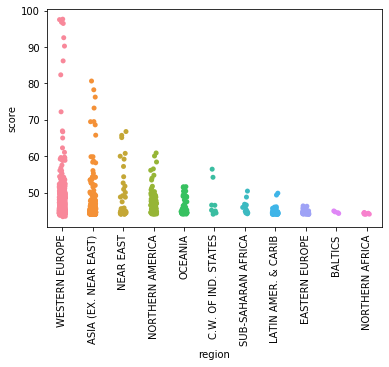

In [15]:
sb.stripplot(x="region", y="score", data=cwur_countr_reg, jitter=True)
plt.xticks(rotation=90)

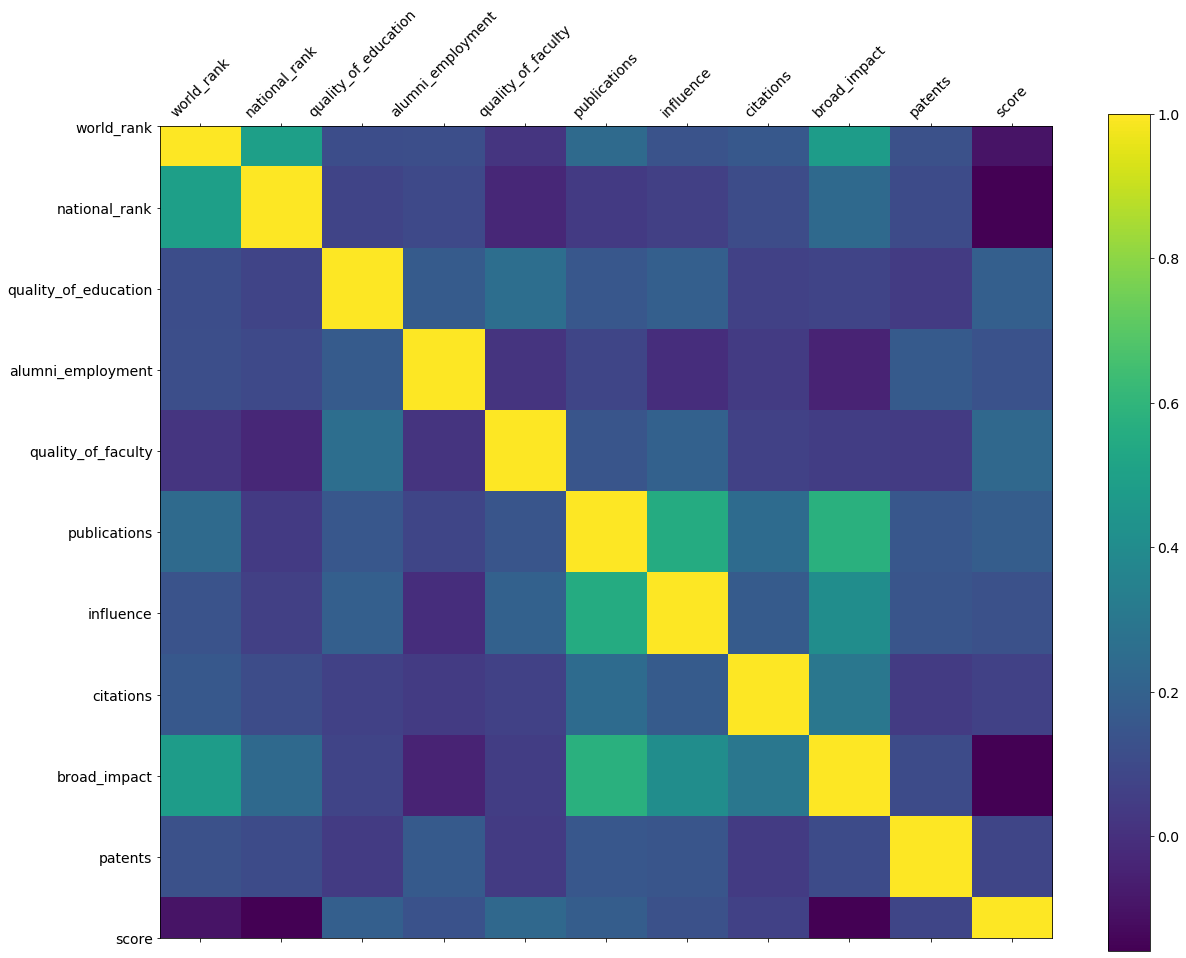

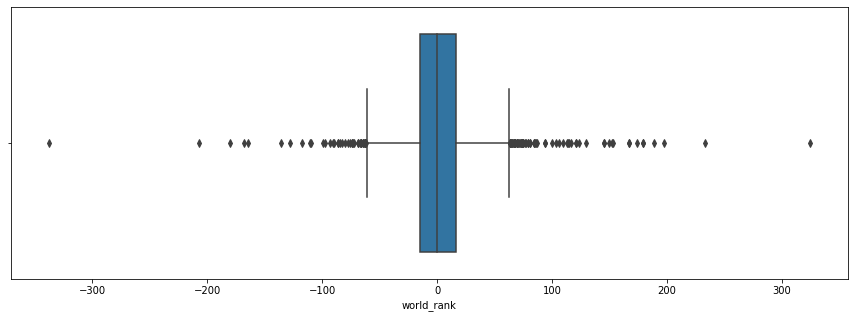

In [16]:
cwur_indexed = cwur_imputed.set_index(['year', 'university_name'])


cwur_diff = cwur_indexed.groupby(by='university_name').diff()


#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_diff.corr(), fignum=fig1.number)
plt.xticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


fig1 = plt.figure(figsize=(15, 5))
ax = sb.boxplot(x=cwur_diff['world_rank'])



In [17]:
#in this step we merge with cwur_imputed data

#first check if  country names are different in both
country_check =  cwur_imputed[~cwur_imputed['country'].isin(hdi_ref['country'])]
print(country_check.country.unique())

#merge
cwur_hdi = pd.merge(cwur_imputed, hdi_ref, left_on=['year','country'], right_on = ['year','country'])


['Taiwan' 'Puerto Rico']


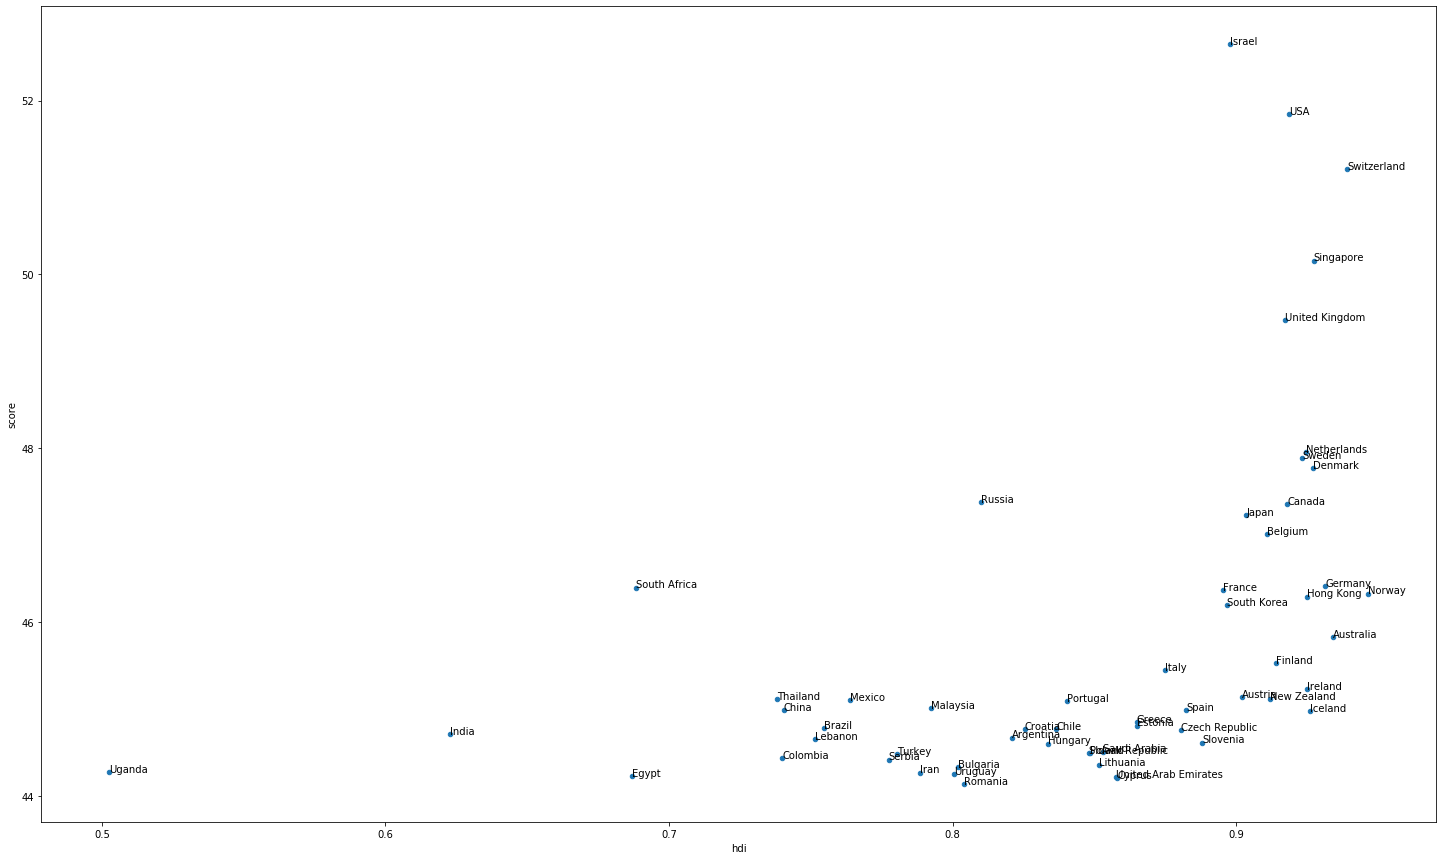

In [18]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby("country").mean()

fig, ax = plt.subplots()
cwur_hdi_mean.plot("hdi", "score", kind="scatter",
             figsize = (25,15), ax=ax)

for k, v in cwur_hdi_mean.iterrows():
    x = v["hdi"]
    y = v["score"]
    ax.annotate(k, (x,y))
      
plt.show()


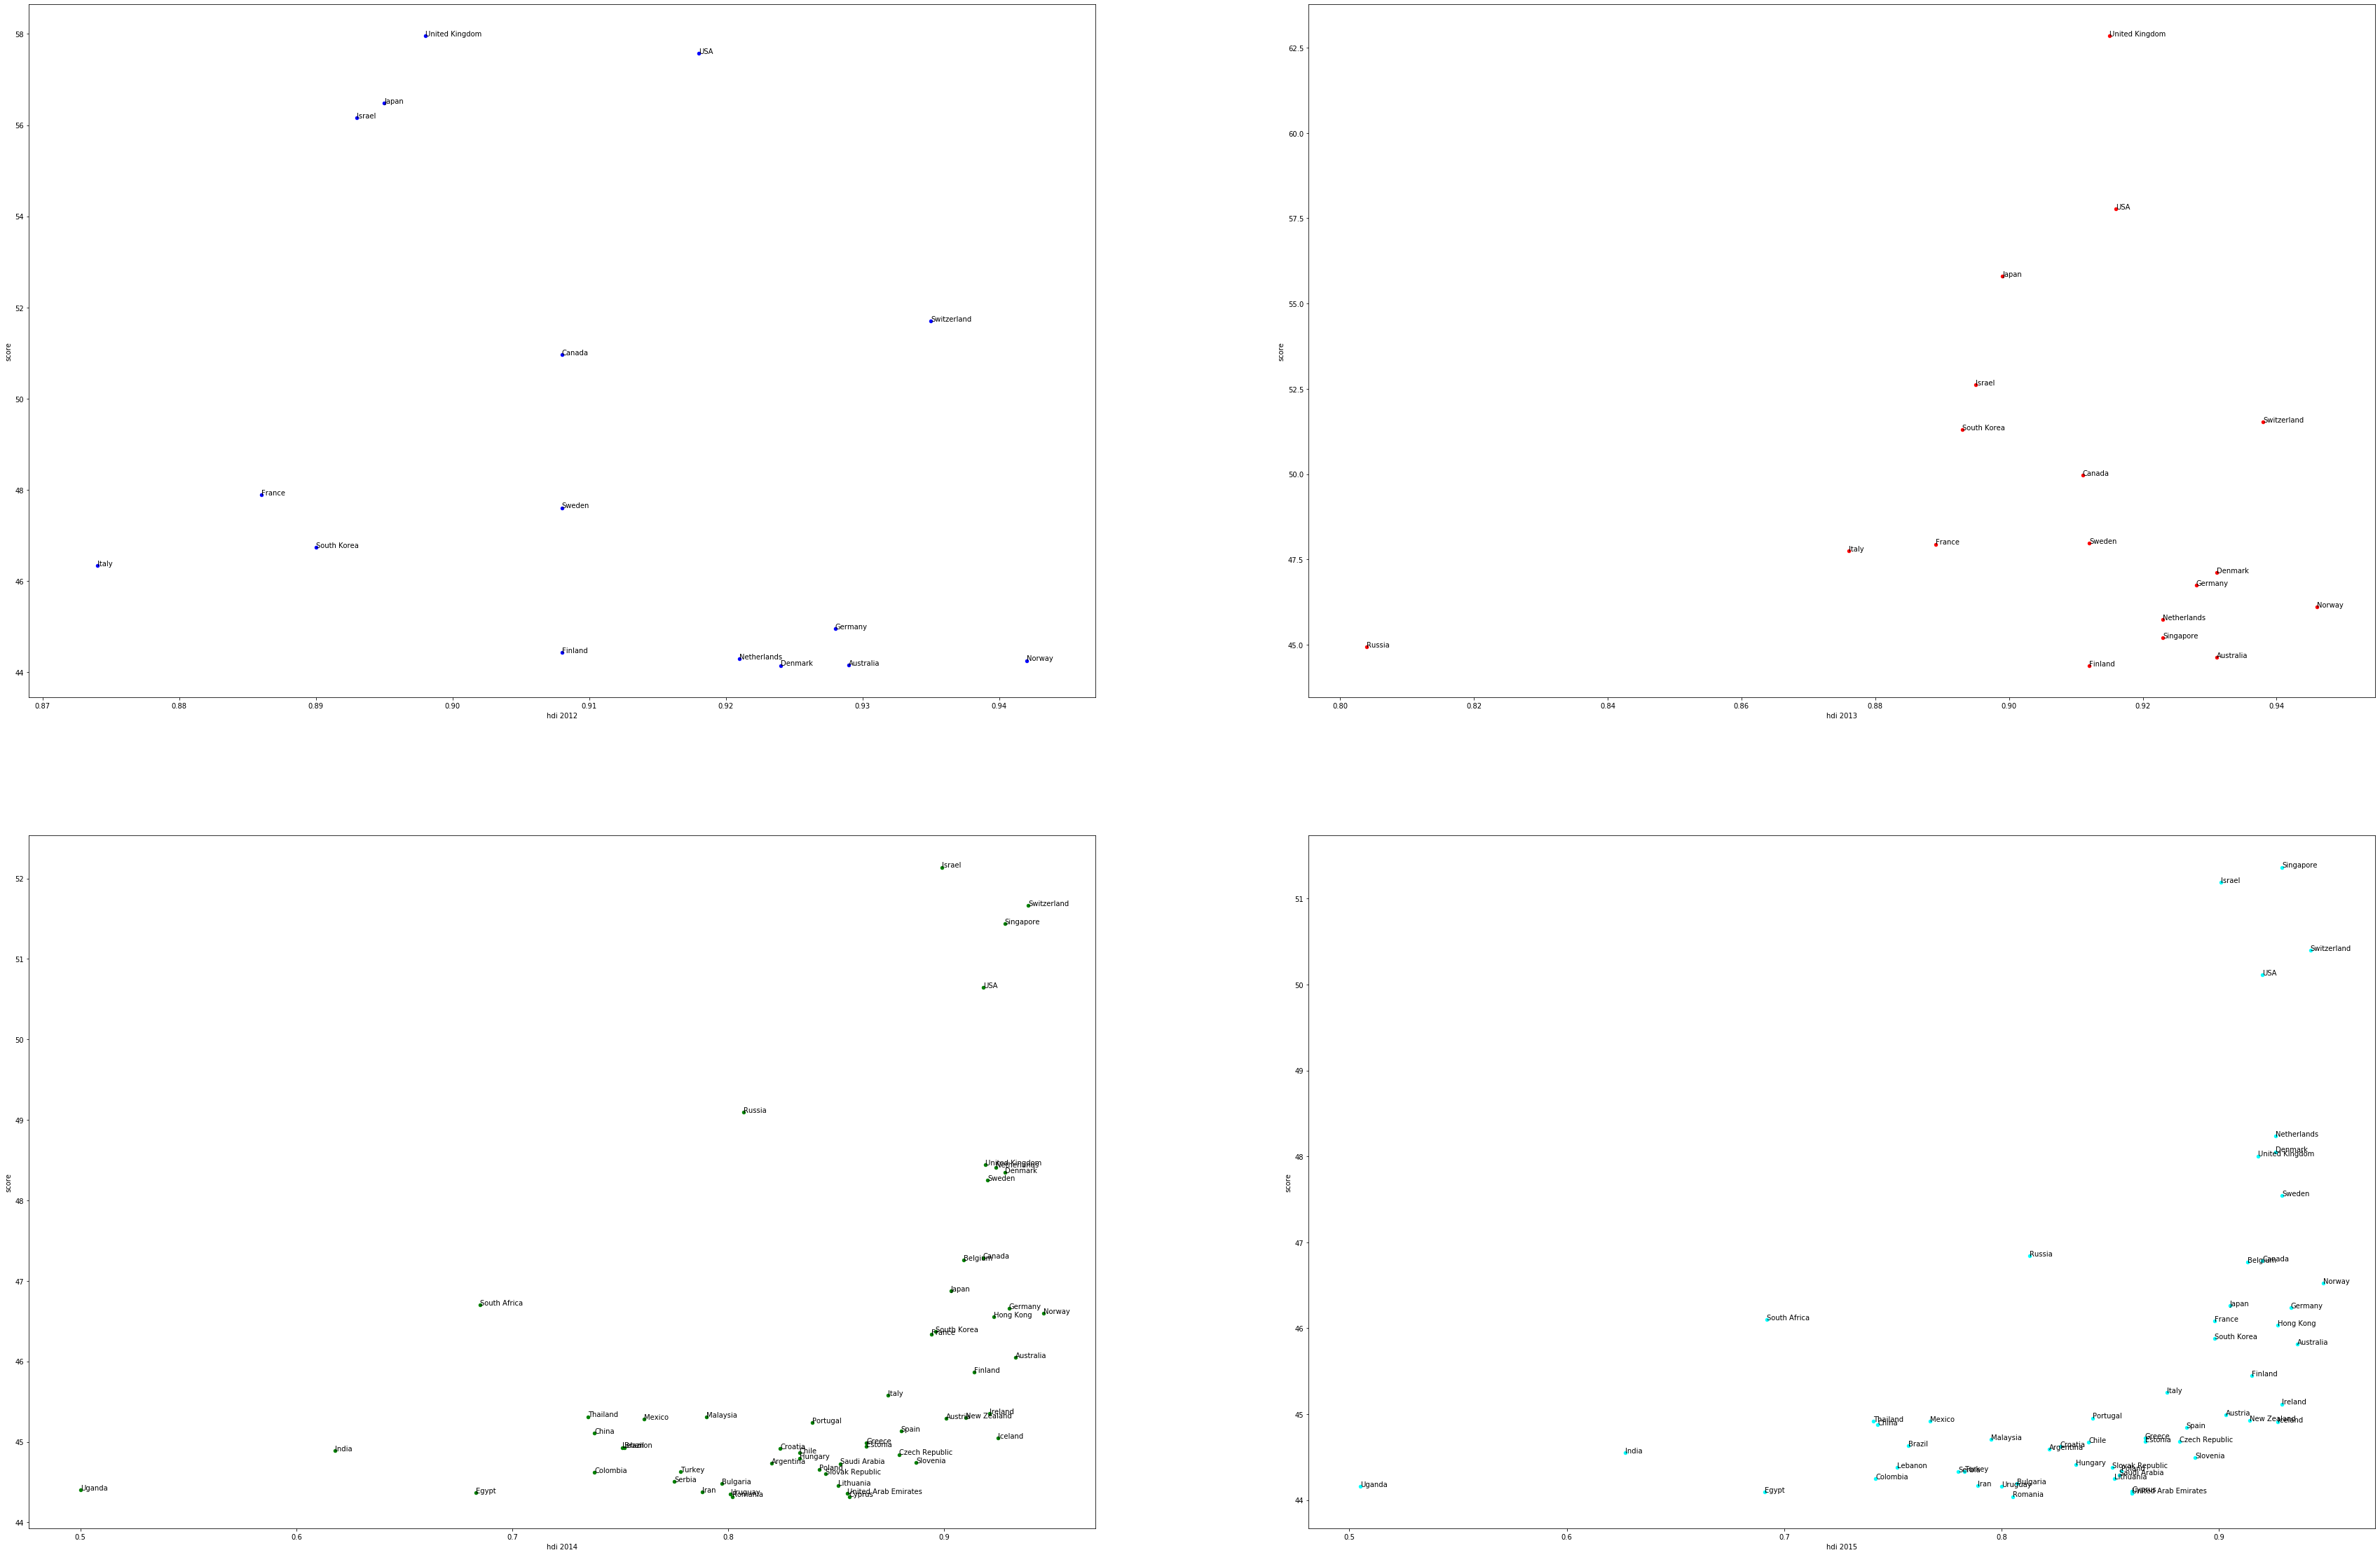

In [19]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby(["year", "country"]).mean()
cwur_hdi_mean12 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2012.0]
cwur_hdi_mean13 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2013.0]
cwur_hdi_mean14 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2014.0]
cwur_hdi_mean15 = cwur_hdi_mean.iloc[cwur_hdi_mean.index.get_level_values('year') == 2015.0]

fig, axs = plt.subplots(nrows=2, ncols=2)
cwur_hdi_mean12.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[0,0], color = "blue")
axs[0,0].set_xlabel("hdi 2012")


for k, v in cwur_hdi_mean12.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,0].annotate(k[1], (x,y))

cwur_hdi_mean13.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[0,1], color = "red")
axs[0,1].set_xlabel("hdi 2013")
for k, v in cwur_hdi_mean13.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[0,1].annotate(k[1], (x,y))

cwur_hdi_mean14.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[1,0], color = "green")
axs[1,0].set_xlabel("hdi 2014")
for k, v in cwur_hdi_mean14.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,0].annotate(k[1], (x,y))

cwur_hdi_mean15.plot("hdi", "score", kind="scatter",
             figsize = (60,40), ax=axs[1,1], color = "cyan")
axs[1,1].set_xlabel("hdi 2015")
for k, v in cwur_hdi_mean15.iterrows():
    x = v["hdi"]
    y = v["score"]
    axs[1,1].annotate(k[1], (x,y))
    
    
plt.show()


In [20]:
cwur.set_index(["year", "university_name"], inplace=True)

### Public expenditures on education per country

We would like to find out how the expenditures for public education influences the rank of the universities of a country. Unfortuneatly, the data containing the expenditures and the data from the CWUR ranking have different time ranges. Therefore we will only group the data by country and look what effect a country's expenditures have on the mean, maximal and minimal score. This is done for the total expenditure (i.e. for all public institutions) as well as for higher education institutions only.

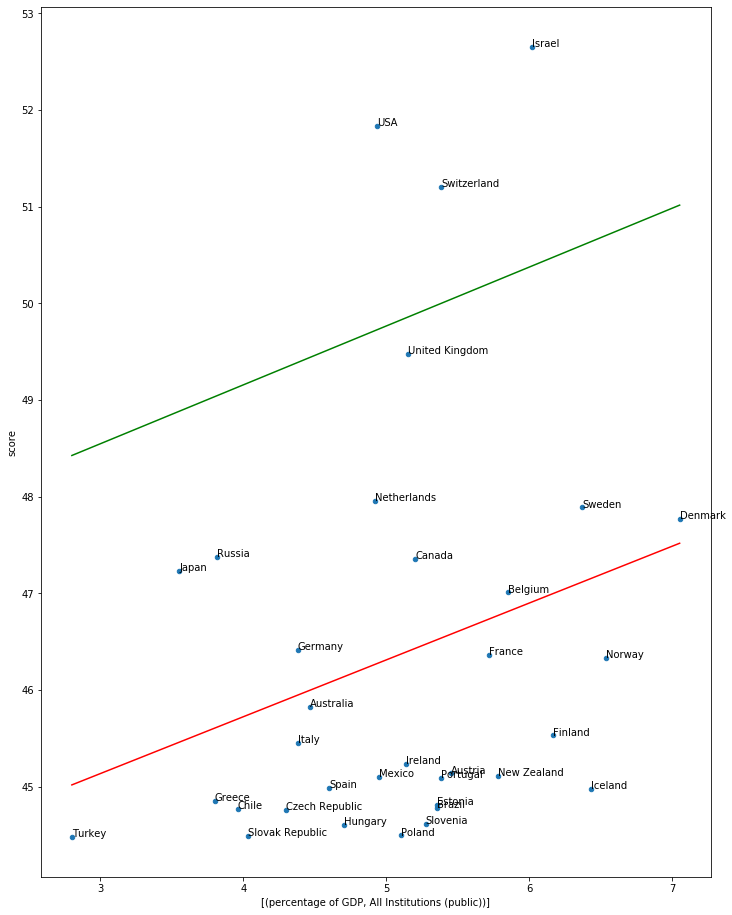

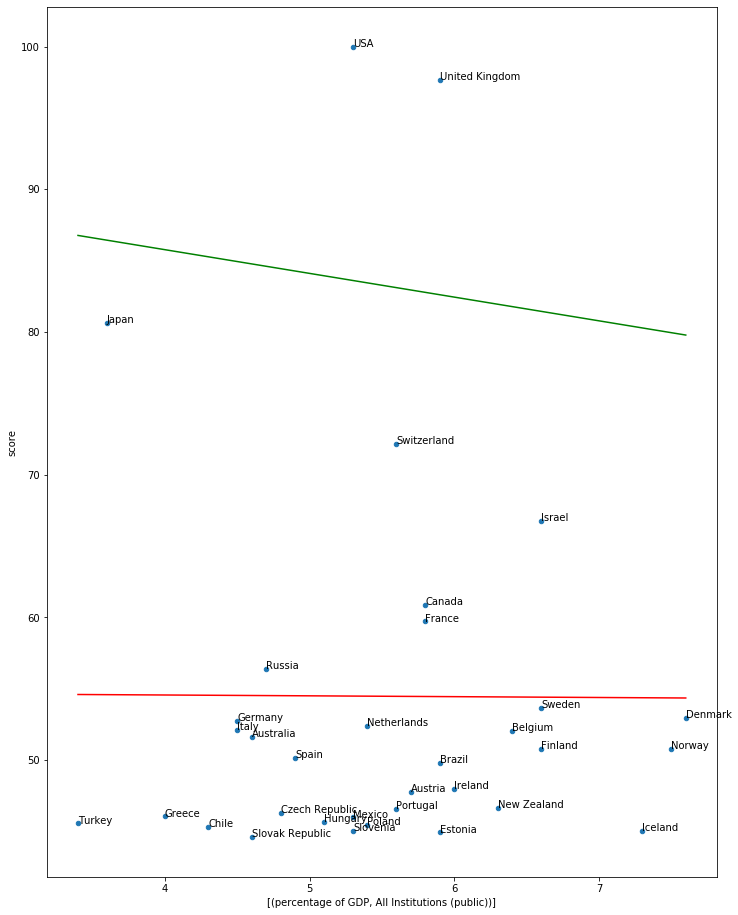

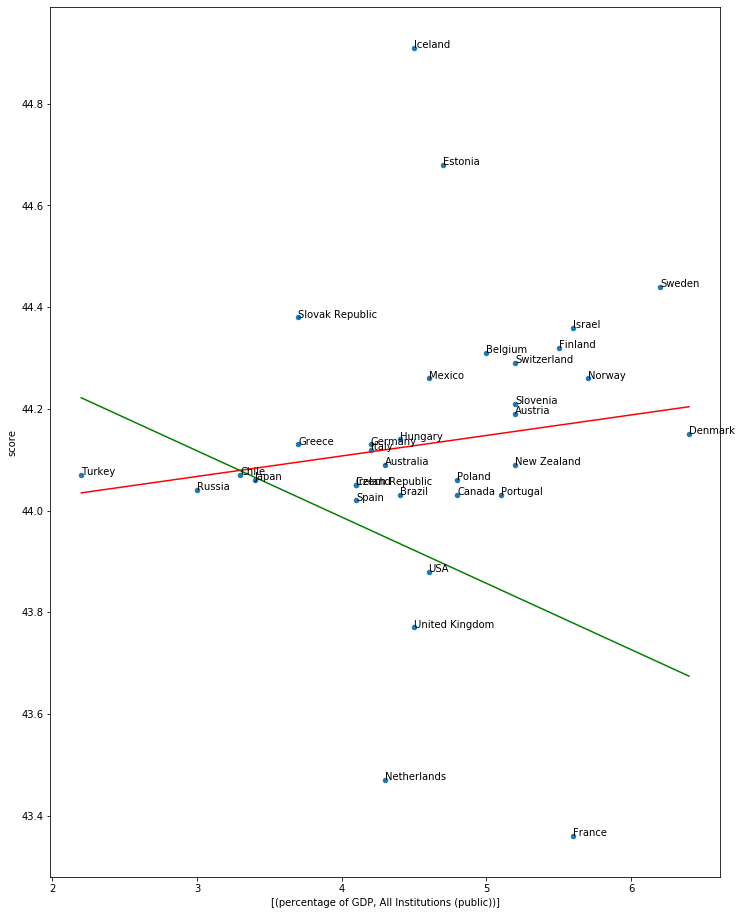

In [21]:
cwur2 = cwur_exp.groupby("country").mean()
cwur3 = cwur_exp.groupby("country").max()
cwur4 = cwur_exp.groupby("country").min()

fig, ax = plt.subplots()

cwur2.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur2[('percentage of GDP', 'All Institutions (public)')]
y=cwur2["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur2["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur2.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
    
plt.show()

fig, ax = plt.subplots()
cwur3.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur3[('percentage of GDP', 'All Institutions (public)')]
y=cwur3["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur3["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")


for k, v in cwur3.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig, ax = plt.subplots()
cwur4.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur4[('percentage of GDP', 'All Institutions (public)')]
y=cwur4["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")

b, m = polyfit(x,y, 1, w=cwur4["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur4.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

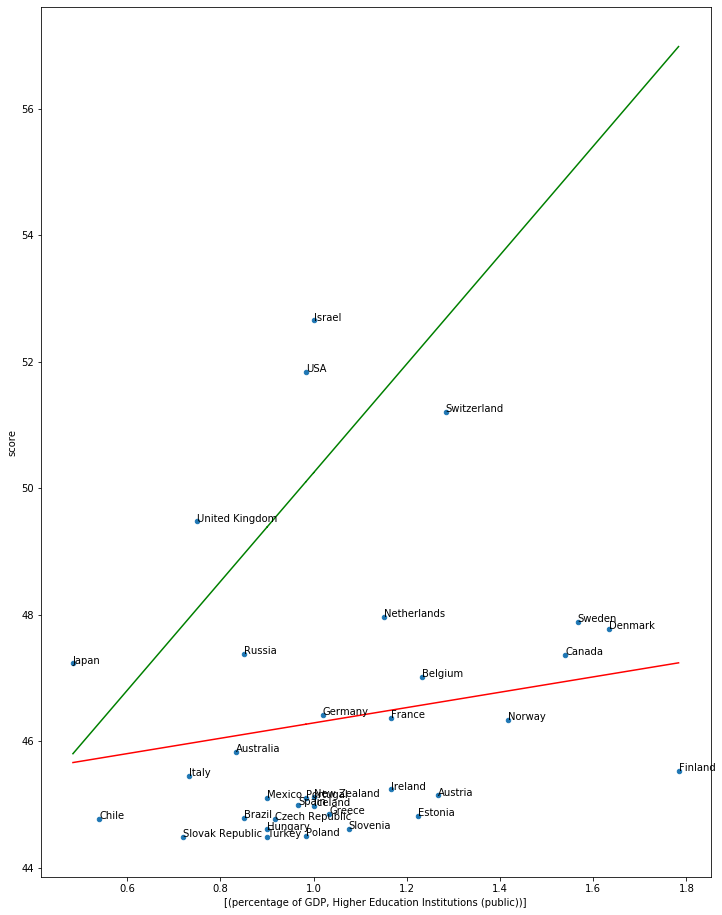

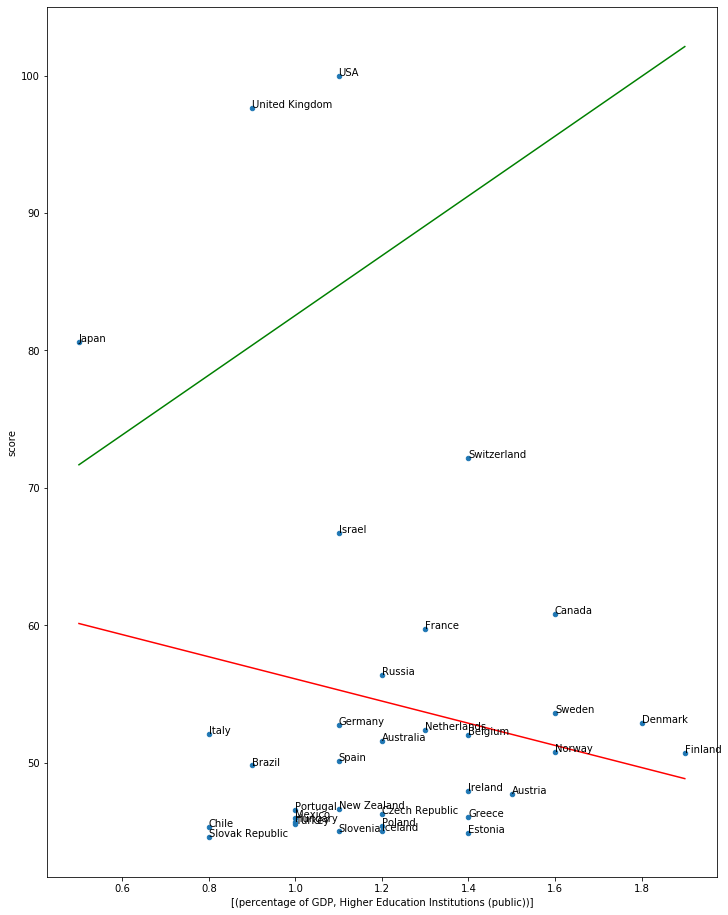

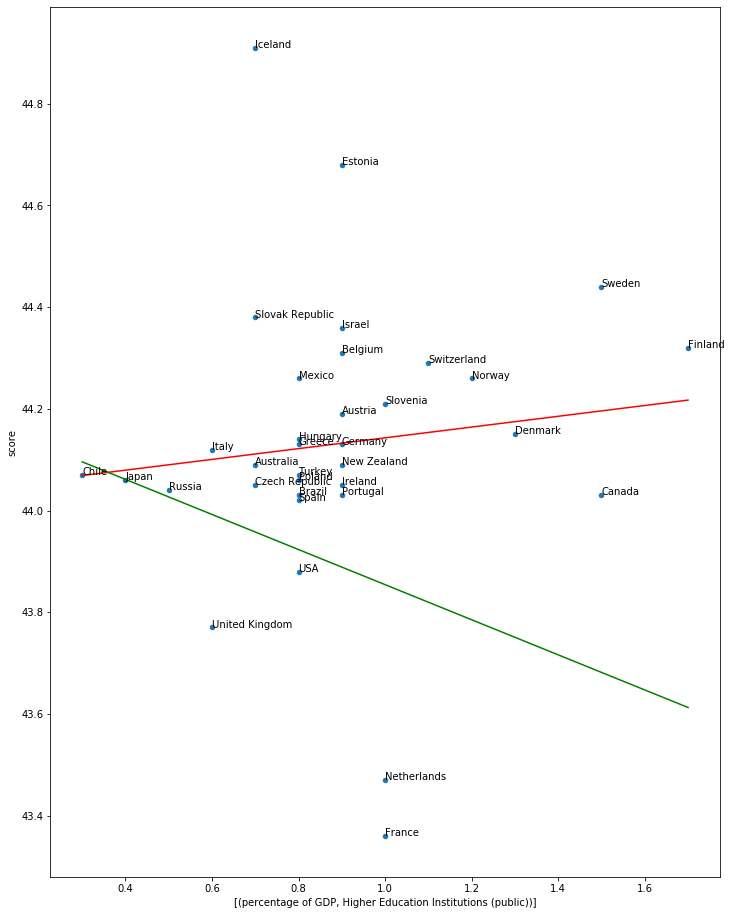

In [22]:
cwur2 = cwur_exp.groupby("country").mean()
fig, ax = plt.subplots()

cwur2.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur2[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur2["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")

b, m = polyfit(x,y, 1, w=cwur2["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")


for k, v in cwur2.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig, ax = plt.subplots()
cwur3.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur3[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur3["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur3["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur3.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig, ax = plt.subplots()
cwur4.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (12,16), ax=ax)
x=cwur4[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur4["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red")
b, m = polyfit(x,y, 1, w=cwur4["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green")

for k, v in cwur4.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

We conclude that...

                                                    (percentage of GDP, Higher Education Institutions (public))  \
(percentage of GDP, Higher Education Institutio...                                           1.000000             
(percentage of GDP, Elementary and Secondary In...                                           0.510719             
...                                                                                               ...             
inhabitants                                                                                 -0.328352             
number of universities                                                                      -0.239543             

                                                    (percentage of GDP, Elementary and Secondary Institutions (public))  \
(percentage of GDP, Higher Education Institutio...                                           0.510719                     
(percentage of GDP, Elementary and Secondary In...             

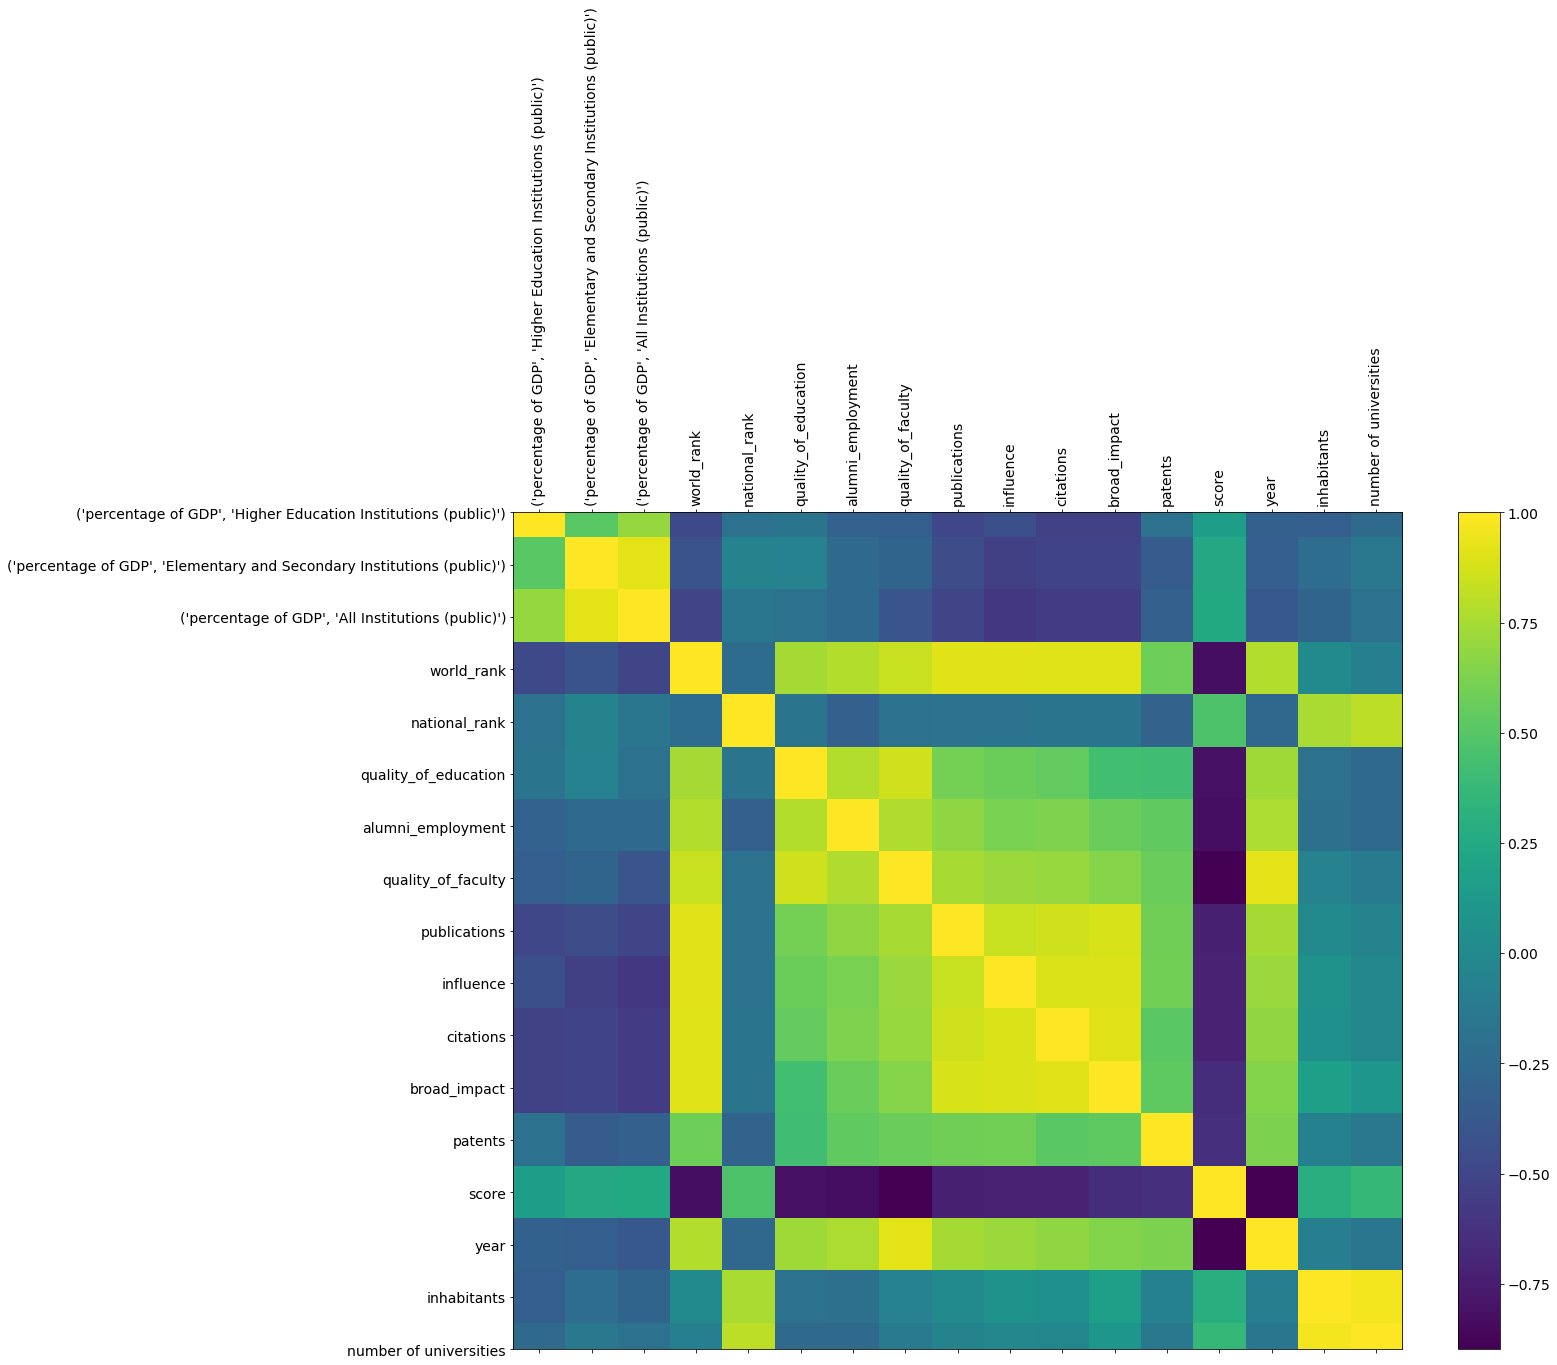

In [23]:
#Heatmap
print(cwur2.corr())

fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur2.corr(), fignum=fig1.number)
plt.xticks(range(cwur2.shape[1]), cwur2.columns, fontsize=14, rotation=90)
plt.yticks(range(cwur2.shape[1]), cwur2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

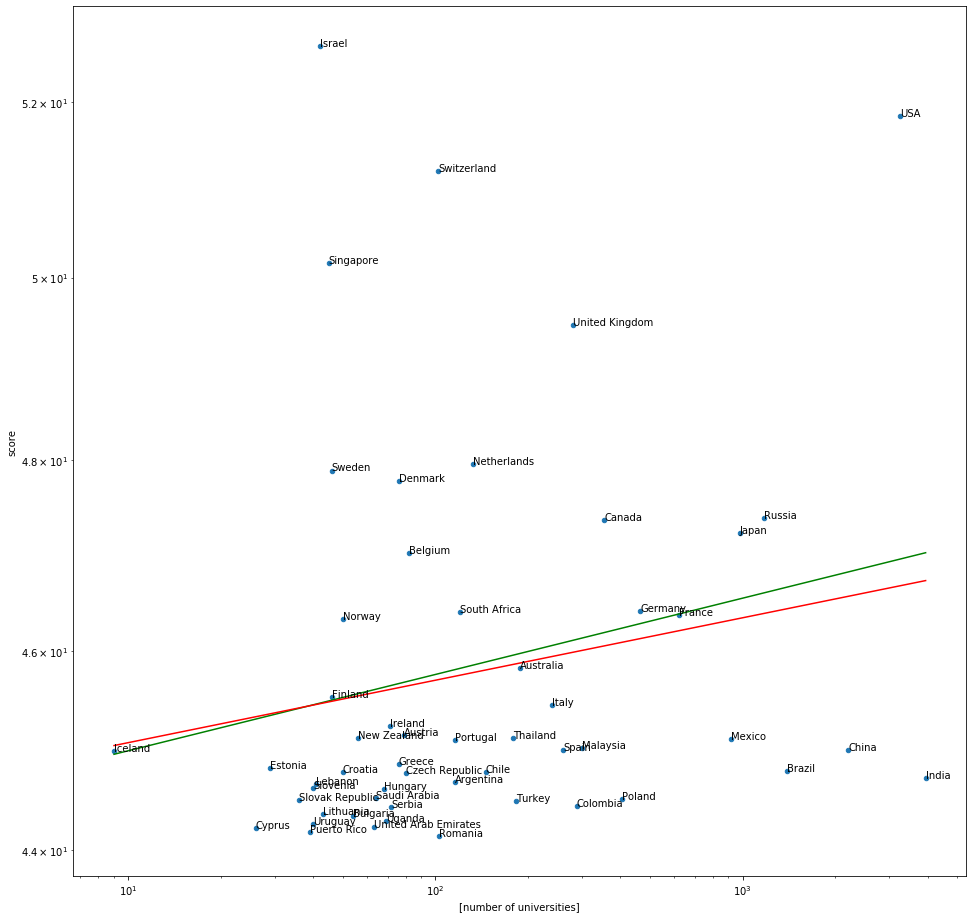

In [24]:
cwur_inh2 = cwur_inh.groupby("country").mean()
cwur_inh2["universities per inhabitant log"] = np.log(cwur_inh2["universities per inhabitant"])
cwur_inh2["inhabitants log"] = np.log(cwur_inh2["inhabitants"])
cwur_inh2["universities log"] = np.log(cwur_inh2["number of universities"])
cwur_inh2["score log"] = np.log(cwur_inh2["score"])


fig, ax = plt.subplots()
cwur_inh2.plot([('number of universities')], "score", kind="scatter",
             figsize = (16,16), ax=ax)


ax.set_xscale('log')
ax.set_yscale('log')

x=np.log(cwur_inh2[("number of universities")])
y=np.log(cwur_inh2["score"])
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()), np.exp(b + m * x.sort_values()), '-', color="green")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()), np.exp(b + m * x.sort_values()), '-', color="red")


for k, v in cwur_inh2.iterrows():
    x = v['number of universities']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

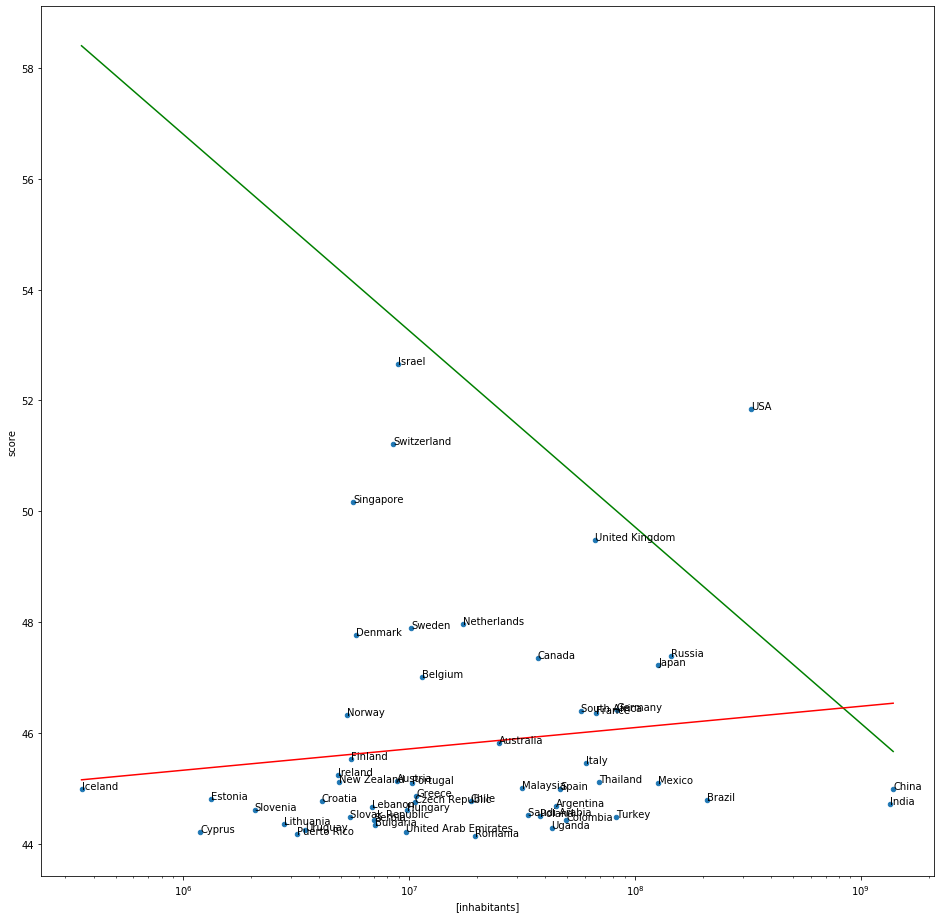

In [25]:
cwur_inh2 = cwur_inh.groupby("country").mean()
fig, ax = plt.subplots()
cwur_inh2.plot([('inhabitants')], "score", kind="scatter",
             figsize = (16,16), ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')

x=np.log(cwur_inh2[("inhabitants")])
y=cwur_inh2["score"]
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()), b + m * x.sort_values(), '-', color="green")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()), b + m * x.sort_values(), '-', color="red")


for k, v in cwur_inh2.iterrows():
    x = v['inhabitants']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

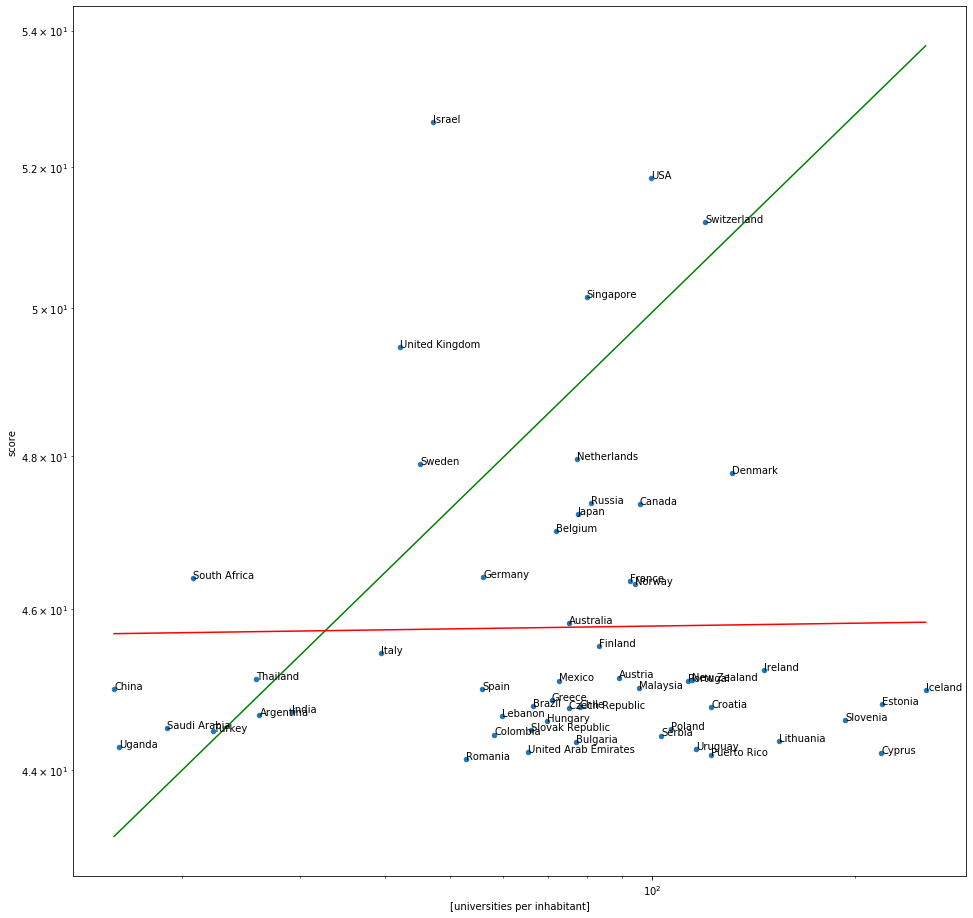

In [26]:
cwur_inh2 = cwur_inh.groupby("country").mean()
fig, ax = plt.subplots()

cwur_inh2.plot([('universities per inhabitant')], "score", kind="scatter",
             figsize = (16,16), ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

x=np.log(cwur_inh2[("universities per inhabitant")])
y=np.log(cwur_inh2["score"])
# b, m = polyfit(x,y, 1, w = np.log(cwur_inh2["number of universities"]))
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()),np.exp(b + m * x.sort_values()), '-', color="green")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()),np.exp(b + m * x.sort_values()), '-', color="red")


for k, v in cwur_inh2.iterrows():
    x = v['universities per inhabitant']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

In [27]:
cwur_inh2["score"].sort_values()

country
Romania        44.133333
Puerto Rico    44.175000
                 ...    
USA            51.839860
Israel         52.654091
Name: score, Length: 54, dtype: float64

                             inhabitants  number of universities  world_rank  \
inhabitants                     1.000000                0.828656    0.047084   
number of universities          0.828656                1.000000   -0.067763   
...                                  ...                     ...         ...   
year                            0.073429               -0.060568    0.722774   
universities per inhabitant    -0.290075               -0.214150    0.029968   

                             national_rank  quality_of_education  \
inhabitants                       0.351385              0.064838   
number of universities            0.599893             -0.084566   
...                                    ...                   ...   
year                             -0.259573              0.607136   
universities per inhabitant      -0.122471              0.161271   

                             alumni_employment  quality_of_faculty  \
inhabitants                          -0.

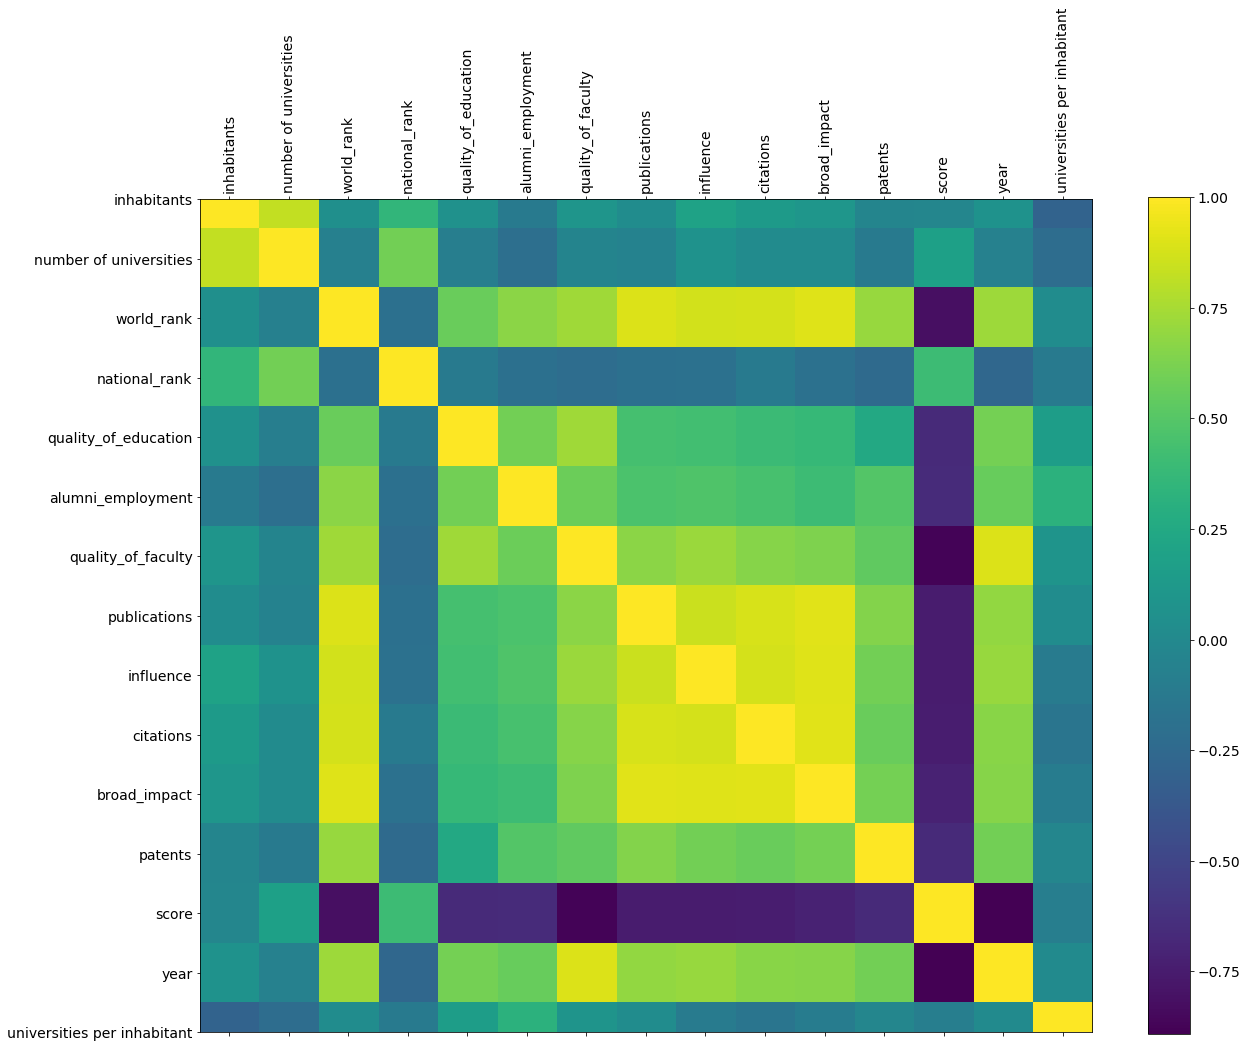

In [28]:
#Heatmap
print(cwur_inh2.corr())
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_inh2.corr(), fignum=fig1.number)
plt.xticks(range(cwur_inh2.shape[1]), cwur_inh2.columns, fontsize=14, rotation=90)
plt.yticks(range(cwur_inh2.shape[1]), cwur_inh2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Next we check whether there are any missing values in the data and clean the data accordingly.

One goal is to investigate whether and how expenditure for education affects university ranks. For this we need to load the relevant data (which is also available via the above kaggle repository).

This dataset has to be extensively reformatted before working with it, as we need the different years as values in a year column and the different kinds of expenditures should show up in different rows. This is done by the code below. The file was first cleaned manually by deleting the initial spaces of several rows. Furthermore some country names have to be replaced in order to be able to match the country names with the Shanghai ranking

Now the expenditure data is merged to the Shanghai data. As the Shanghai data contains precise ranks only for ranks below 100, we add a column "world_rank_rand_between" containing a random rank between the minimal and the maximal rank. This is mainly done in order to plot the data in a reasonable way.

## Step 2: Explore the data

After having read in the data, we can now explore the data.

## Step 3: Model the data

In [29]:
hdi_score = cwur_hdi_mean[[ 'hdi', 'world_rank']]


#encode categorical variable for model training
#hdi_score['institution']  = encInst.transform(hdi_score['institution'])
#hdi_score['country'] =  encCon.transform(hdi_score['country'])

# y is the actual data we want to predict
y = np.array(hdi_score['world_rank'])

#drop data we want to predict from table
x= hdi_score.drop(('world_rank'), axis = 1)

# Convert to numpy array
x = np.array(x)

# Save feature names for visualization later
feature_list = list(hdi_score.columns)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.8, random_state = 101)

print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)
#hdi_score

Training Features Shape: (29, 1)
Training Labels Shape: (29,)
Testing Features Shape: (119, 1)
Testing Labels Shape: (119,)


In [30]:
#train model

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#fit model
rf.fit(train_x, train_y)


#predict
pred = rf.predict(test_x)

In [31]:
#check performance metrics


error = abs(pred - test_y)

#calculate mean error to see how much our average estimate is off by
print('Mean Absolute Error:', round(np.mean(error), 2), 'degrees.')
rf.score(pred.reshape(-1,1),test_y.reshape(-1,1))





Mean Absolute Error: 188.35 degrees.


-1.2336424711648108

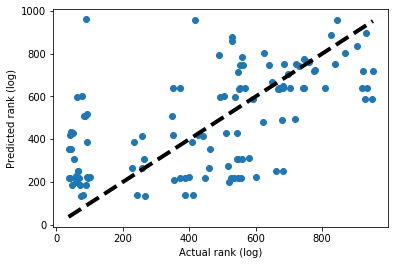

In [32]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual rank (log)')
ax.set_ylabel('Predicted rank (log)')
plt.show()


In [33]:
times

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,USA,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,USA,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,700,Yokohama National University,Japan,20.1,23.3,16.0,13.5,40.4,-,"10,117",12.1,8%,28 : 72,2016
2602,700,Yuan Ze University,Taiwan,16.2,17.7,18.3,28.6,39.8,-,"8,663",20.6,4%,43 : 57,2016


In [34]:
times = times.dropna()
times= times[['num_students', 'total_score']]
times['num_students'] = times['num_students'].replace(",", ".")
times['num_students'] = pd.to_numeric(times['num_students'])
display(times['total_score'])
#= pd.to_numeric(times['total_score'])
#times[times.num_students.str.contains('[^0-9]' ,regex = True)]['num_students'].unique()




ValueError: Unable to parse string "2,243" at position 0

In [ ]:
#times.plot('total_score', 'num_students')
plt.scatter(times['total_score'], times['num_students'])
plt.show()